#### Загрузим наборы данных и импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import math
import json
import time
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

In [2]:
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Загрузка данных

In [ ]:
books = pd.read_csv("../input/bookcrossing/BX-Books.csv", sep=";", error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

In [4]:
users = pd.read_csv('../input/bookcrossing/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

In [5]:
ratings = pd.read_csv('../input/bookcrossing/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

# Проведем анализ данных

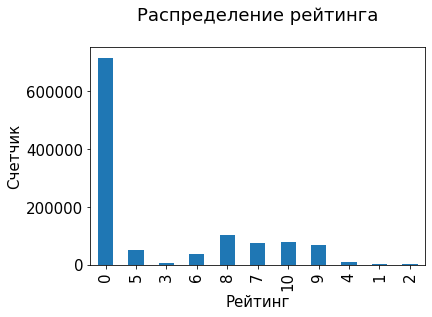

In [6]:
plt.rc("font", size=15)
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Распределение рейтинга\n')
plt.xlabel('Рейтинг')
plt.ylabel('Счетчик')
plt.show()

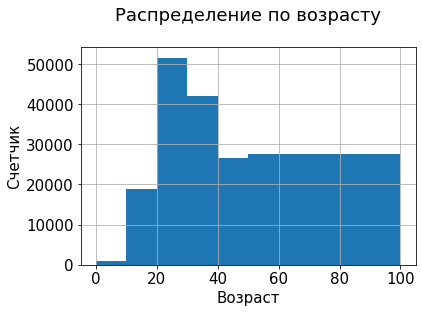

In [7]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Распределение по возрасту\n')
plt.xlabel('Возраст')
plt.ylabel('Счетчик')
plt.show()

### Проверим количество записей и признаков, указанных в каждом наборе данных

In [8]:
books.shape,users.shape,ratings.shape

((271360, 8), (278858, 3), (1149780, 3))

In [9]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Удаление последних трех столбцов, содержащих URL-адреса изображений, которые не потребуются для анализа

In [10]:
books = books.iloc[:,:5]

In [11]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


### Проверка уникальных значений yearOfPublication

In [12]:
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication    object
publisher            object
dtype: object

In [13]:
bookspub = books['yearOfPublication']

In [14]:
bookspub.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Как видно из вышеизложенного, в этом поле есть несколько некорректных записей. Похоже, что имена издателей «DK Publishing Inc» и «Gallimard» были неправильно загружены как yearOfPublication в наборе данных из-за некоторых ошибок в CSV-файле.

### Проверим строки, содержащие «DK Publishing Inc» в качестве yearOfPublication

In [15]:
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


### Удалим строки, содержащие `'DK Publishing Inc'` и `'Gallimard'` как `yearOfPublication`

In [16]:
books = books[(books.yearOfPublication != 'DK Publishing Inc') & (books.yearOfPublication != 'Gallimard')]

### Изменим тип данных yearOfPublication на 'int'

In [17]:
books['yearOfPublication'] = books['yearOfPublication'].astype('int32')

In [18]:
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication     int32
publisher            object
dtype: object

### Удалим NaN в столбце `'publisher'`

In [19]:
#drop NaNs in 'publisher' column
books = books.dropna(subset=['publisher'])
books.publisher.isnull().sum()

0

## Изучение набора данных о пользователях

In [20]:
print(users.shape)
users.head()

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### Получим все уникальные значения в порядке возрастания для столбца `Возраст`

In [21]:
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

В столбце «Возраст» есть некоторые недопустимые записи, такие как nan, 0 и очень высокие значения, такие как 100 и выше.

### Значения ниже 5 и выше 90 не имеют особого смысла для нашего случая рейтинга книг... поэтому заменим их на NaN

In [22]:
import numpy as np
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

### Заменим нулевые значения в столбце «Возраст» на среднее

In [23]:
users['Age'] = users['Age'].fillna(users['Age'].mean())

### Изменим тип данных `Age` на `int`

In [24]:
users['Age'] = users['Age'].astype(int)

In [25]:
print(sorted(users.Age.unique()))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


## Изучение набора данных Ratings

### Проверим форму

In [26]:
ratings.shape

(1149780, 3)

In [27]:
n_users = users.shape[0]
n_books = books.shape[0]
n_users,n_books

(278858, 271355)

In [28]:
ratings.head(5)

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Набор данных Ratings должен содержать только те книги, которые существуют в нашем наборе данных о книгах. Удалим оставшиеся строки

In [29]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

In [30]:
ratings_new.shape

(1031130, 3)

### Набор данных Ratings должен содержать оценки пользователей, которые существуют в наборе данных пользователей. Удалим оставшиеся строки

In [31]:
ratings_new = ratings_new[ratings.userID.isin(users.userID)]

In [32]:
ratings_new.shape

(1031130, 3)

### Узнаем, какая оценка была дана наибольшее количество раз

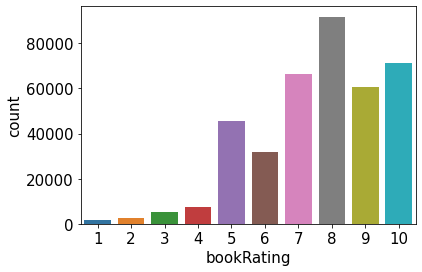

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()

### **Системы рекомендаций на основе совместной фильтрации**

### Для получения более точных результатов будем учитывать только тех пользователей, которые оценили не менее 500 книг.

In [34]:
counts1 = pd.value_counts(ratings_explicit['userID'])

In [35]:
counts1

11676     6943
98391     5689
189835    1899
153662    1845
23902     1180
          ... 
114767       1
114771       1
114772       1
114777       1
276721       1
Name: userID, Length: 68091, dtype: int64

In [36]:
ratings_explicit_new = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 500].index)]

In [37]:
ratings_explicit_new.shape

(29411, 3)

In [38]:
ratings_explicit = ratings_explicit_new.copy()

### Преобразование данных в формат "surprise"

In [39]:
!pip install surprise

In [40]:
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 10))

In [41]:
ratings_explicit.head(2)

,userID,ISBN,bookRating
45339,11676,0001944711,6
45340,11676,0002005018,8


In [42]:
ratings_explicit.shape

(29411, 3)

In [43]:
data = Dataset.load_from_df(ratings_explicit[['userID', 'ISBN', 'bookRating']], reader)

In [44]:
data.df.head(2)

,userID,ISBN,bookRating
45339,11676,0001944711,6
45340,11676,0002005018,8


### Обратим внимание:

1) Trainset больше не является типом данных pandas. Теперь он имеет вид, определенные библиотекой Surprise.

2) UserID и ISBN в  данных pandas могут содержать любое значение (либо строку, либо целое число и т. д.). Однако Trainset преобразует эти необработанные идентификаторы в числовые индексы, называемые «внутренним идентификатором».

### Система рекомендаций на основе SVD

In [45]:
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings_explicit[['userID', 'ISBN', 'bookRating']], reader)


In [46]:
# Разделим данные для обучения и тестирования

from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25,random_state=123)


In [47]:
from surprise import SVD, KNNWithMeans
from surprise import accuracy

In [48]:
svd_model = SVD(n_factors=5)
svd_model.fit(trainset)

In [49]:
testset[0]

(153662, '006108185X', 9.0)

In [50]:
test_pred = svd_model.test(testset)

In [51]:
test_pred[0:5]

[Prediction(uid=153662, iid='006108185X', r_ui=9.0, est=8.540807600198129, details={'was_impossible': False}),
 Prediction(uid=11676, iid='0671577026', r_ui=9.0, est=7.370831833886747, details={'was_impossible': False}),
 Prediction(uid=95359, iid='0609804138', r_ui=10.0, est=7.781144855123485, details={'was_impossible': False}),
 Prediction(uid=98391, iid='0451208838', r_ui=9.0, est=8.767583168360368, details={'was_impossible': False}),
 Prediction(uid=11676, iid='3453146980', r_ui=4.0, est=7.370831833886747, details={'was_impossible': False})]

# Вычислим среднеквадратичное отклонение

In [52]:
accuracy.rmse(test_pred)

RMSE: 1.4983


1.4982739748239142

## KNN С Means

In [53]:
from surprise import KNNWithMeans
from surprise import accuracy

algo_i = KNNWithMeans(k=10, sim_options={ 'user_based': False})
algo_i.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [54]:
test_pred=algo_i.test(testset)
print(accuracy.rmse(test_pred))

RMSE: 1.8790
1.8789856860600966


## svd_model дал лучшие результаты.

In [55]:
uid = str(98391)  # необработанный идентификатор пользователя (как в файле оценок).
iid = "074323748X"  # необработанный идентификатор элемента (как в файле оценок)

# получить прогноз для конкретных пользователей и элемента.
pred = svd_model.predict(uid, iid, r_ui=0.0, verbose=True)

user: 98391      item: 074323748X r_ui = 0.00   est = 7.73   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


### Создание первых n рекомендаций

In [56]:
pred = pd.DataFrame(test_pred)
pred[pred['uid'] == 98391][['iid', 'r_ui','est']].sort_values(by = 'r_ui',ascending = False).head(10)

,iid,r_ui,est
7351,045121269X,10.0,7.733249
2139,042519597X,10.0,7.733249
5063,0425190021,10.0,7.733249
2241,0553803085,10.0,8.016667
5066,0373293224,10.0,7.733249
5079,0778320294,10.0,7.733249
5100,0743247566,10.0,7.733249
2188,045121174X,10.0,7.733249
2187,0060013133,10.0,7.733249
2182,0765303957,10.0,7.733249


Модель прогнозирует средний рейтинг, если оценка невозможна

Совместная фильтрация на основе моделей — это персонализированная рекомендательная система, рекомендации основаны на прошлом поведении пользователя и не зависят от какой-либо дополнительной информации.

Система рекомендаций на основе популярности не является персонализированной, а рекомендации основаны на подсчете частоты, что может не подходить пользователю.